In [8]:
import os
import pickle
import pandas as pd
import numpy as np
import pcntoolkit as ptk 
from pcntoolkit.dataio.fileio import load as ptkload
from pcntoolkit.dataio.fileio import save as ptksave
from pcntoolkit.normative import predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix, calibration_descriptives

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pingouin as pg

from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from pathlib  import Path

# globals
root_dir = '/project_cephfs/3022017.06/ENIGMA_ANX/'


###  CHANGE DEPENDING ON Z-STAT OR SCALED EFFECT  ###
proc_dir = os.path.join(root_dir,'Z_stat/')
#proc_dir = os.path.join(root_dir,'Scaled_effect/')


data_dir = os.path.join(proc_dir,'data/')
w_dir = os.path.join(proc_dir,'vox/')
mask_nii = ('/opt/fmriprep/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii.gz')
ex_nii = os.path.join(data_dir, 'ENIGMA_FC_tr_1.nii.gz')


In [2]:
# Load in the Z_est files
Z_est_control_test = ptkload(os.path.join(w_dir,'Z_estimate.pkl'), mask=mask_nii)
Z_est_clinical = ptkload(os.path.join(w_dir,'Z_predcl.pkl'), mask=mask_nii)

In [3]:
#Load in the diagnosis information
metadata_cl_diagnosis = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/clinical_te.csv')
Diagnoses_info = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/data/all_test_validation.csv', usecols = ['SubjectID_ENIGMA', 'Principal_diagnosis_current'] )
merged_clinical_test_data = pd.merge(metadata_cl_diagnosis, Diagnoses_info, on='SubjectID_ENIGMA', how='left')

merged_clinical_test_data['Principal_diagnosis_current'] = merged_clinical_test_data['Principal_diagnosis_current'].replace({np.nan: 'NA', 'nan': 'NA'})
Primary_Diagnoses = np.unique(merged_clinical_test_data['Principal_diagnosis_current'])

print(merged_clinical_test_data)
print(Primary_Diagnoses)

          Group_Dataset    SubjectID_ENIGMA SubjectID_neuroimage  \
0    Barcelona_Cardoner   enigmafc_cond_251            sub-CHMTM   
1    Barcelona_Cardoner   enigmafc_cond_237            sub-CHCSM   
2    Barcelona_Cardoner   enigmafc_cond_243            sub-CHJCS   
3    Barcelona_Cardoner   enigmafc_cond_241            sub-CHHCO   
4    Barcelona_Cardoner   enigmafc_cond_261            sub-CMGFF   
..                  ...                 ...                  ...   
576           USP_Diniz  enigmafc_cond_1991            sub-20031   
577           USP_Diniz  enigmafc_cond_1992            sub-20033   
578           USP_Diniz  enigmafc_cond_1993            sub-20034   
579           USP_Diniz  enigmafc_cond_1994            sub-20035   
580           USP_Diniz  enigmafc_cond_1995            sub-20036   

     Healthy_or_patient  Age  Sex  MRI  Instructions  Precond_number_trials  \
0                     0   19  0.0    0             0                     32   
1                     0  

In [5]:
#split the Z_est clinical into the control and patients  ***and remove other and schizophrenia as diagnosis are not of interest***
mask_Diganosis = merged_clinical_test_data['Healthy_or_patient'].eq(1)
mask_exclude_diagnosis = ~merged_clinical_test_data['Principal_diagnosis_current'].isin(['others', 'schizophrenia'])
 #remove other and schizophrenia as not primary affective conditions 
combined_Diagnosis_mask = mask_Diganosis & mask_exclude_diagnosis

mask_Control = merged_clinical_test_data['Healthy_or_patient'].eq(0)
Z_est_clinical_only = Z_est_clinical[combined_Diagnosis_mask]
Z_est_control_clin = Z_est_clinical[mask_Control]
print(len(Z_est_control_clin))

260


In [6]:
print(len(Z_est_clinical_only))
Primary_Diagnoses = np.unique(merged_clinical_test_data['Principal_diagnosis_current'])
for d in Primary_Diagnoses:
    mask_Diganosis = Diagnoses_info['Principal_diagnosis_current'].eq(d)
    print( sum(mask_Diganosis == True), d)

222
0 NA
48 gad
11 major depressive disorder
68 ocd
52 others
2 panic disorder
55 ptsd
31 sad
47 schizophrenia
7 specific phobia


In [7]:
#COMPUTE AND SAVE COUNTS -#This means once you have saved the file you can simply load in the csv in future 
reference_counts = []
clinical_counts = []
control_counts = []

for x in range(0,len(Z_est_control_test)):
    reference_counts.append(sum((Z_est_control_test[x] < -2.6) | (Z_est_control_test[x]  > 2.6)))

for y in range(0,len(Z_est_clinical_only)):
    clinical_counts.append(sum((Z_est_clinical_only[y] < -2.6) | (Z_est_clinical_only[y]  > 2.6)))

for z in range(0,len(Z_est_control_clin)):
    control_counts.append(sum((Z_est_control_clin[z] < -2.6) | (Z_est_control_clin[z]  > 2.6)))

reference_counts_df = pd.DataFrame(reference_counts)
control_counts_df = pd.DataFrame(control_counts)
clinical_counts_df = pd.DataFrame(clinical_counts)

#Save as a dataframe -> csv to be able to easily re-run in the future if necessary.
counts_df = pd.concat([reference_counts_df, control_counts_df, clinical_counts_df], ignore_index=True, axis =1 )
counts_df = counts_df.rename(columns = {0:'reference_counts', 1:'control_counts', 2:'clinical_counts'})

counts_df.to_csv(os.path.join('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv'),index=False)      

For future plotting: Load in the counts 

In [9]:
counts_df = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')
counts_df_ref = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')['reference_counts']
counts_df_cont = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')['control_counts']
counts_df_clin = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')['clinical_counts']

reference_counts_df = pd.DataFrame(counts_df_ref)
control_counts_df = pd.DataFrame(counts_df_cont)
clinical_counts_df = pd.DataFrame(counts_df_clin)

reference_counts = counts_df_ref
control_counts = counts_df_cont
clinical_counts = counts_df_clin

results = stats.kruskal(reference_counts, control_counts, clinical_counts, nan_policy = 'omit')

print('Kruskal-Wallis H-test', results[0])
print('p value:', results[1])

Kruskal-Wallis H-test 16.220632840033616
p value: 0.0003004237980470738


In [10]:
#IF SIGNIFICANT DO FOLLOW UP TEST: 

reference_counts_df = pd.DataFrame(counts_df_ref)
control_counts_df = pd.DataFrame(counts_df_cont).dropna()
clinical_counts_df = pd.DataFrame(counts_df_clin).dropna()


results2a = stats.mannwhitneyu(reference_counts_df, control_counts_df)
print("REF vs CONTROL_CLIN")
print('Mann Whitney U-test', results2a[0])
print('p value:', results2a[1])


results2b = stats.mannwhitneyu(reference_counts_df, clinical_counts_df)
print("REF vs CLIN")
print('Mann Whitney U-test', results2b[0])
print('p value:', results2b[1])


results2c = stats.mannwhitneyu(control_counts_df, clinical_counts_df)
print("CONTROL_CLIN vs CLIN")
print('Mann Whitney U-test', results2c[0])
print('p value:', results2c[1])



reference_counts_df = pd.DataFrame(counts_df_ref)
control_counts_df = pd.DataFrame(counts_df_cont).dropna()
clinical_counts_df = pd.DataFrame(counts_df_clin).dropna()

#AND DO FDR CORRECTION:
# Extract p-values from the results
p_values = [results2a[1], results2b[1], results2c[1]]

# Flatten the list of p-values to ensure it's 1-dimensional
p_values_array = np.concatenate([np.ravel(p) for p in p_values])

# Perform multiple testing correction
rejected, corrected_p_values, _, _ = multipletests(p_values_array, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
print(rejected)
print(corrected_p_values)

REF vs CONTROL_CLIN
Mann Whitney U-test [95524.]
p value: [0.00119601]
REF vs CLIN
Mann Whitney U-test [81943.5]
p value: [0.00149016]
CONTROL_CLIN vs CLIN
Mann Whitney U-test [29224.]
p value: [0.81150588]
[ True  True False]
[0.00223524 0.00223524 0.81150588]


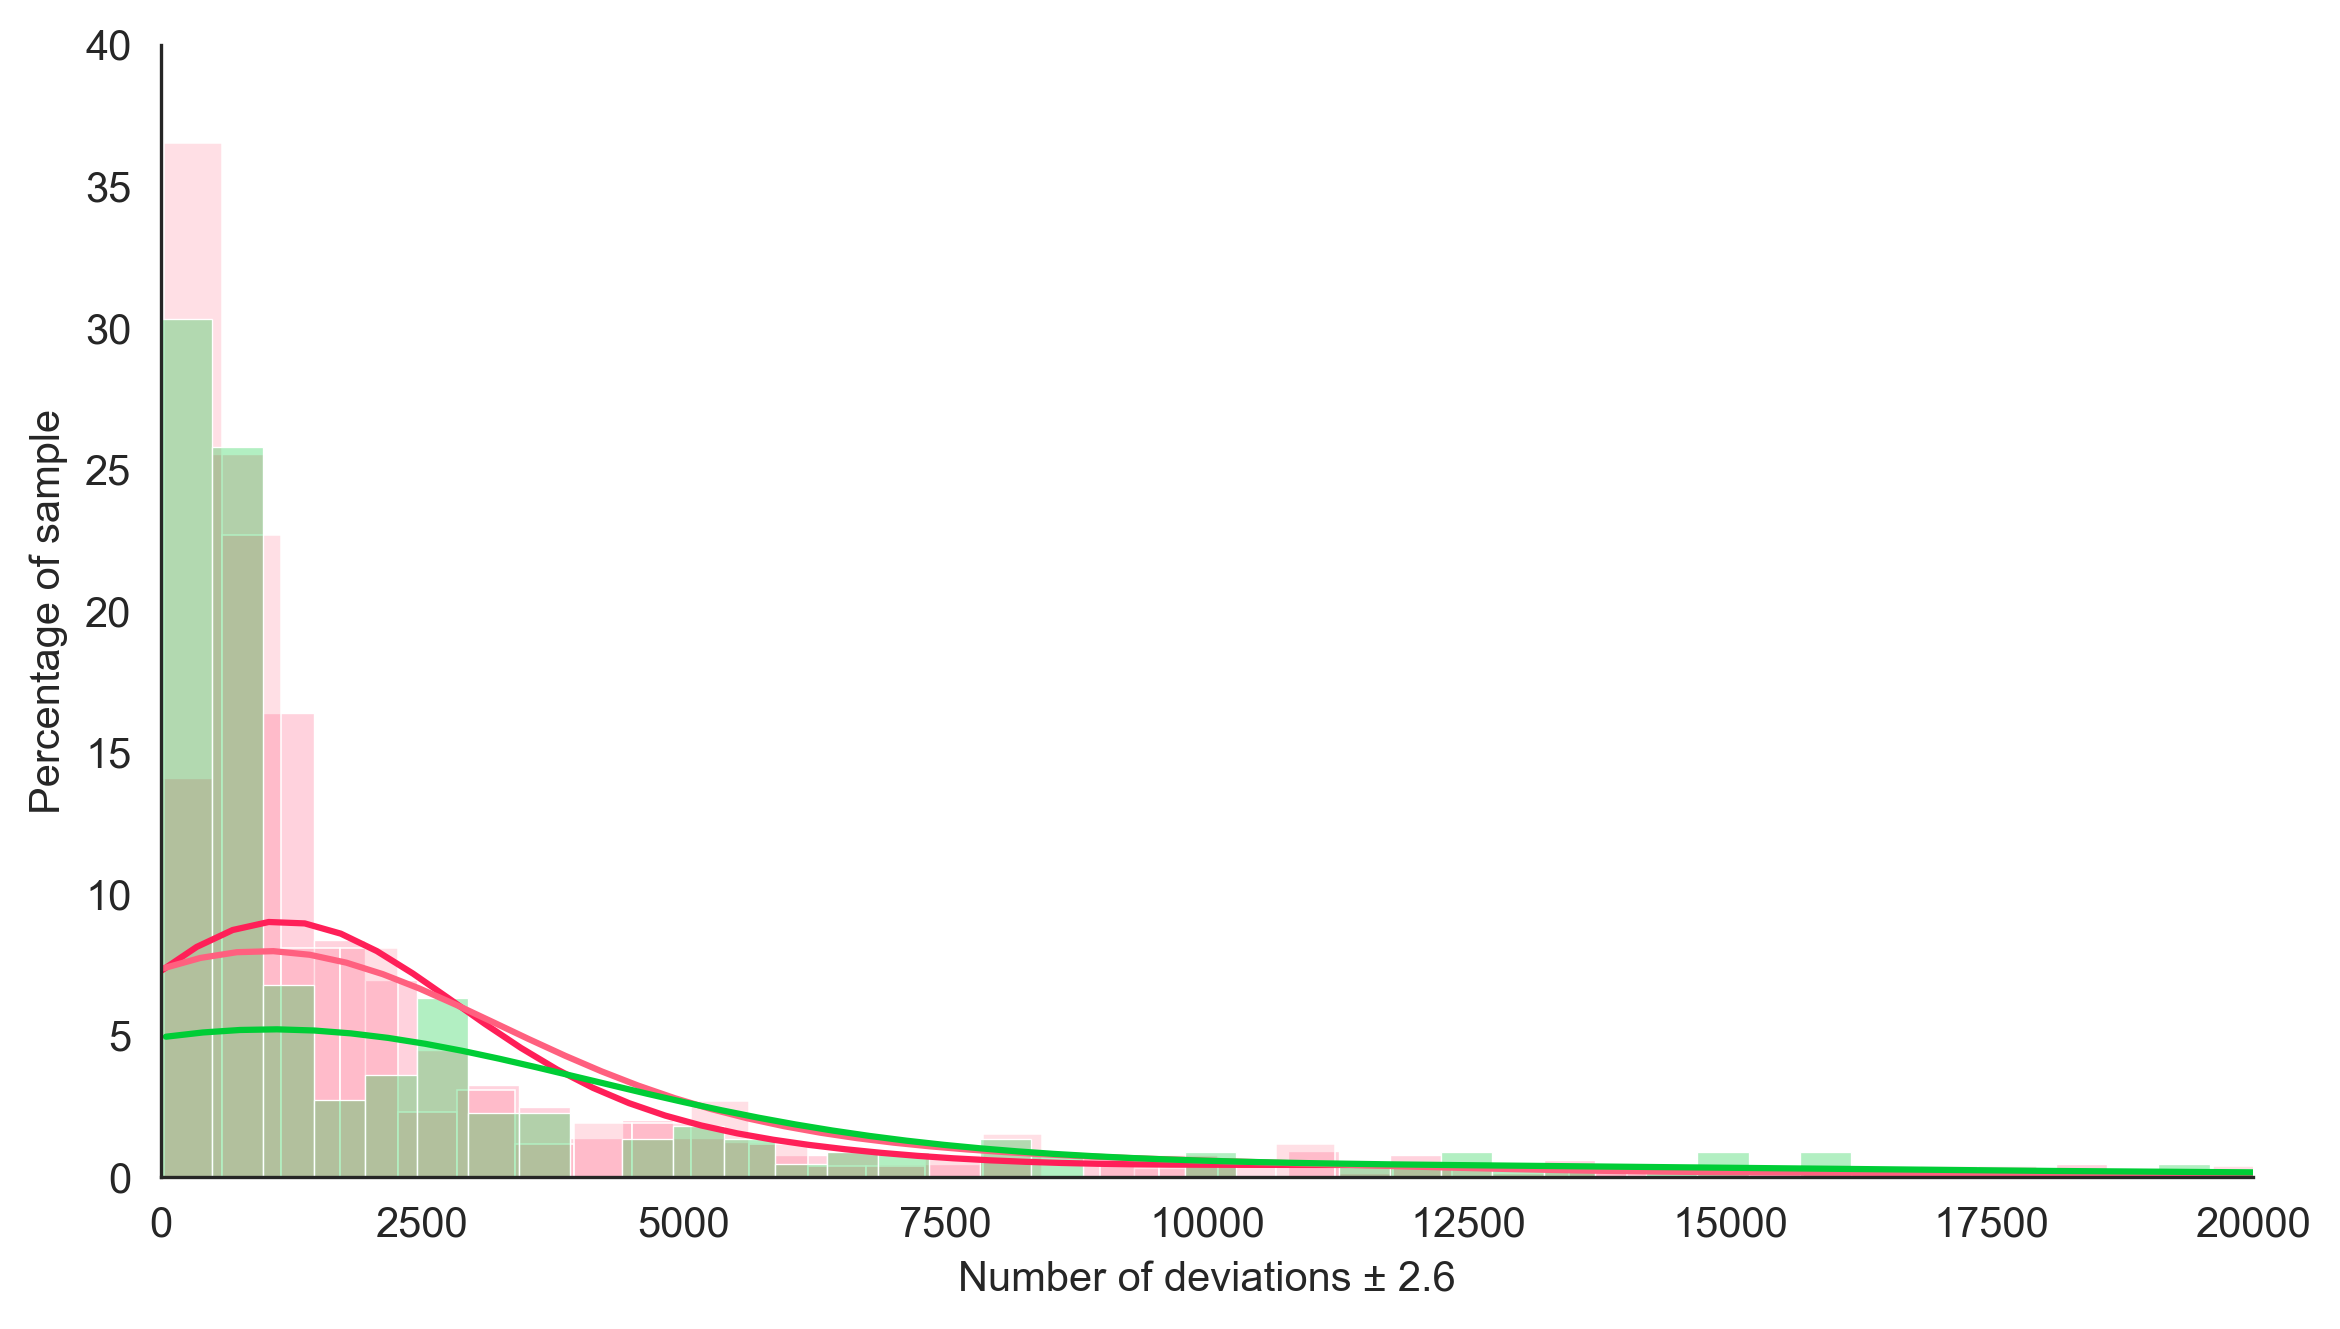

In [36]:
#HISTOGRAM PLOTS

fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")

bins = np.histogram_bin_edges(counts_df['reference_counts'], bins='auto')
boxplt_palette = ['#FF1F58', '#FF607F', '#00CD36']

sns.set_style("white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9,5
fig, ax = plt.subplots()
#sns.boxplot(data = counts_df[['reference_counts', 'control_counts', 'clinical_counts']], showfliers = False, palette=boxplt_palette, orient = 'h')
sns.histplot(data=counts_df, x='reference_counts', color="#FF1F58", label="Reference Cohort", kde=True,  stat="percent", alpha = 0.2, bins=bins)
sns.histplot(data=counts_df, x='control_counts', color="#FF607F", label="MIND Set Controls", kde=True,  stat="percent", alpha = 0.2)
sns.histplot(data=counts_df, x='clinical_counts', color="#00CD36", label="Patients", kde=True, stat="percent", alpha = 0.3, bins=bins)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlim(0,20000)
plt.xticks(font = fpath)
plt.ylim(0,40)
plt.yticks(font = fpath)
plt.xlabel('Number of deviations ± 2.6', font = fpath)
plt.ylabel('Percentage of sample',font = fpath)
#plt.legend(frameon=False) 
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/deviation_count_control_clinical_affective_only.png', dpi=300)


NameError: name 'fpath' is not defined

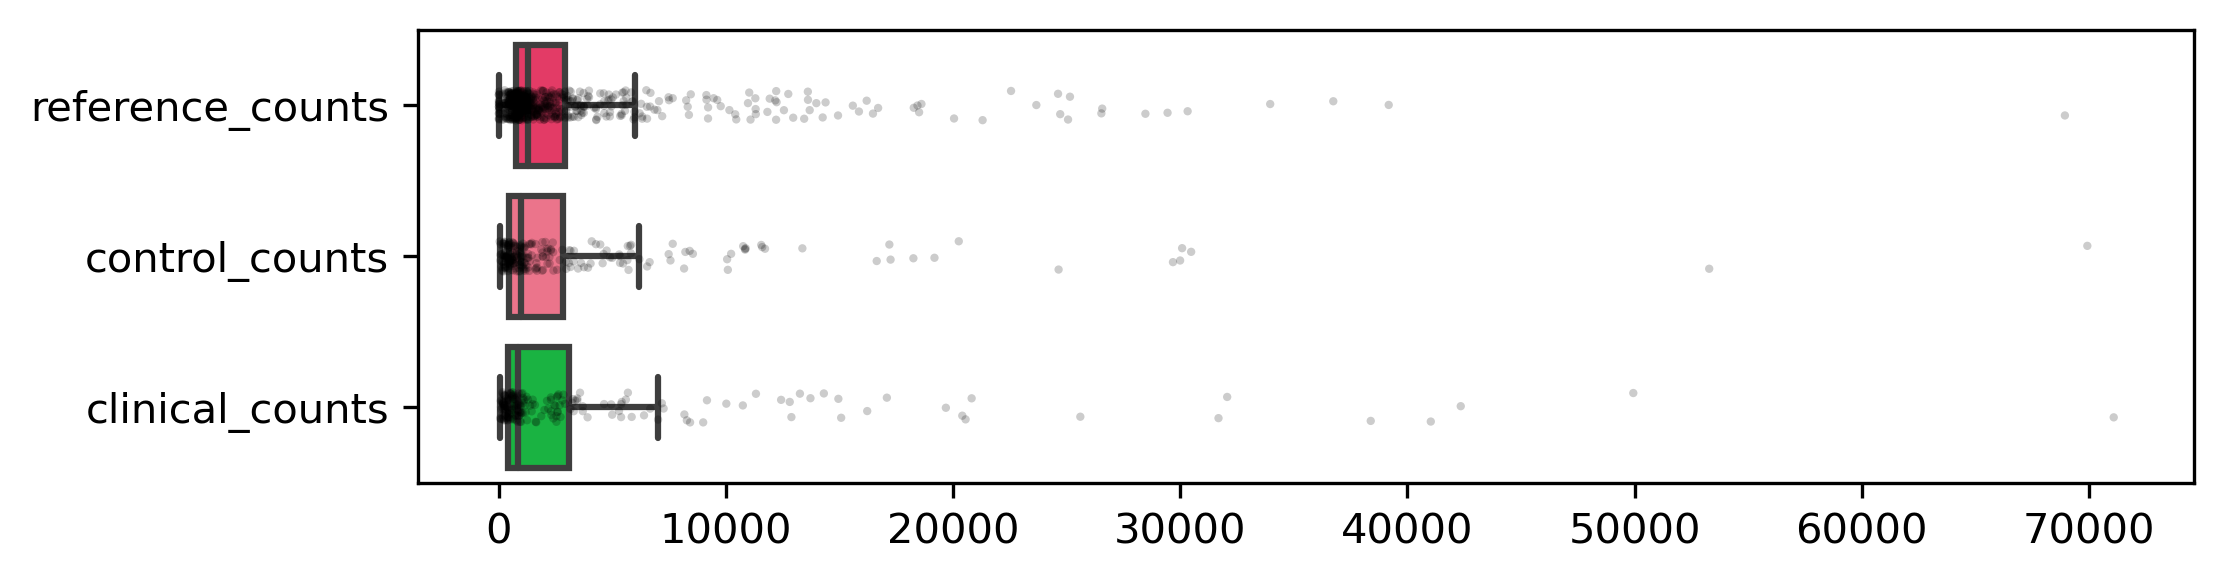

In [11]:
##################
#BOX PLOTS
##################
boxplt_palette = ['#FF1F58', '#FF607F', '#00CD36']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7.64,2
fig, ax = plt.subplots()
sns.set_style("white")
sns.boxplot(data = counts_df[['reference_counts', 'control_counts', 'clinical_counts']], showfliers = False, palette=boxplt_palette, orient = 'h')
sns.stripplot(data = counts_df[['reference_counts', 'control_counts', 'clinical_counts']], marker = "o", size = 2, alpha=0.2, color="black", orient = 'h')
plt.yticks([0,1,2], ['Reference', 'Unaffected \n controls' , 'Patients with \nAnxiety Related Disorder'], font = fpath)
plt.xticks(font = fpath)
plt.xlim(0,20000)
sns.despine(top=False, left=False, bottom=True)
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/deviation_count_control_clincial_boxplot_scat_affective_only.png', dpi=300)


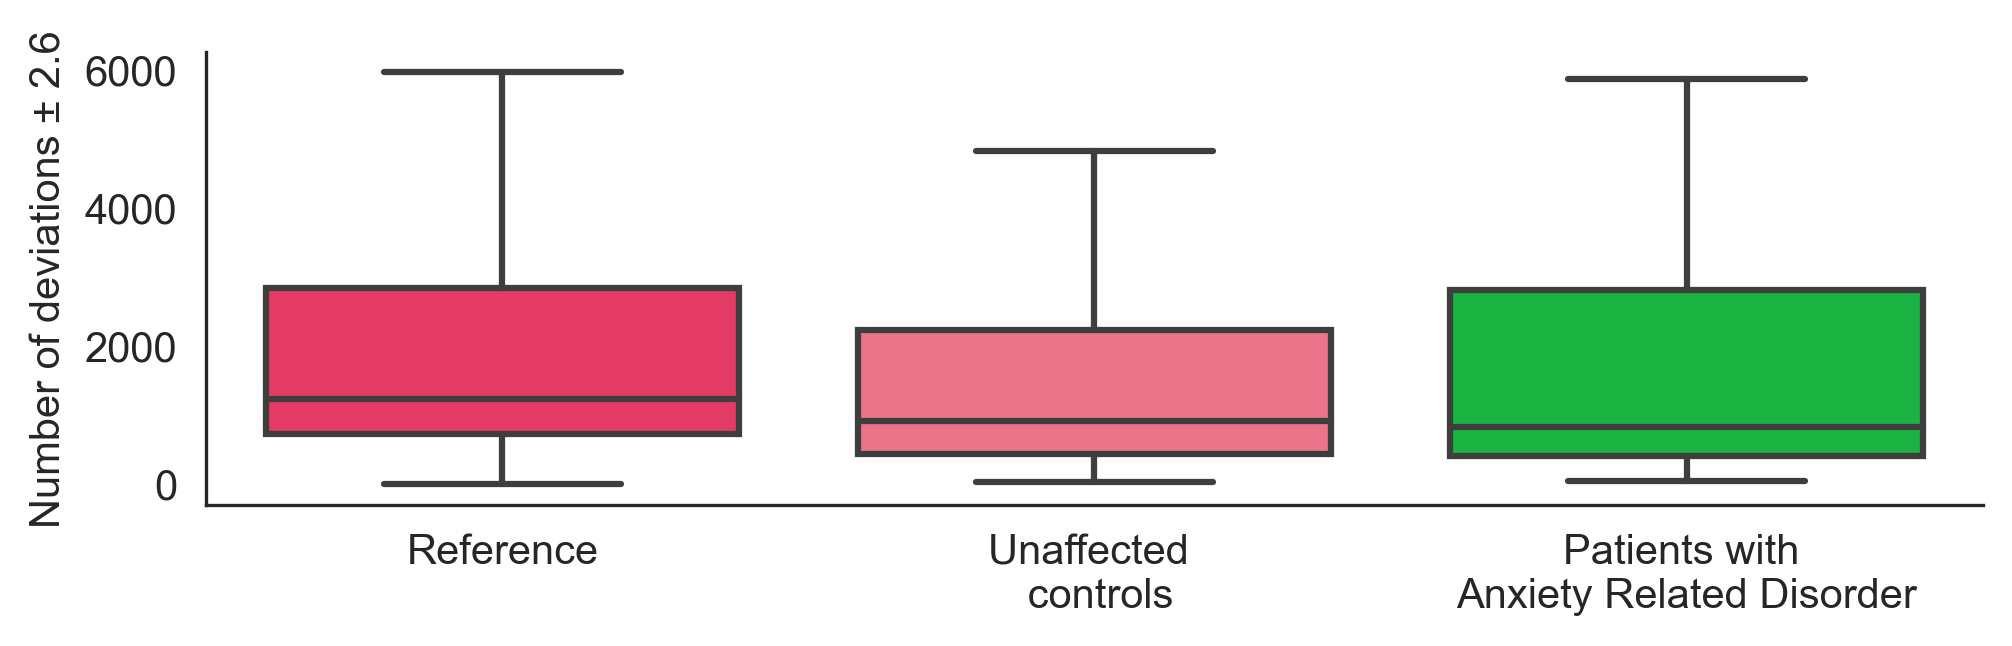

In [38]:
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots()
sns.set_style("white")
sns.boxplot(data = counts_df[['reference_counts', 'control_counts', 'clinical_counts']], showfliers = False, palette=boxplt_palette)
plt.ylabel('Number of deviations ± 2.6', font = fpath)
plt.xticks([0,1,2], ['Reference', 'Unaffected \n controls' , 'Patients with \nAnxiety Related Disorder'], font = fpath)
plt.yticks(font = fpath)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/deviation_count_control_clincial_boxplot_affective_only.png', dpi=300)

In [12]:
import pandas as pd
from scipy import stats

# Step 1: Read the CSV file and extract the relevant columns
counts_df = pd.read_csv('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/vox/NPM_comparisons/counts_hist_affective_only.csv')
reference_counts_df = pd.DataFrame(counts_df['reference_counts'])
control_counts_df = pd.DataFrame(counts_df['control_counts'])
clinical_counts_df = pd.DataFrame(counts_df['clinical_counts'])

# Step 2: Concatenate reference and control counts
control_test = reference_counts_df
clinical_test_controls = control_counts_df
combined_control_test = pd.concat([control_test, clinical_test_controls]).reset_index(drop=True)

# Create a Series for the combined controls with index aligned
combined_control_test_series = pd.Series(combined_control_test.values.flatten(), name='Unaffected \nControls')

# Step 3: Perform the Kruskal-Wallis H-test
results = stats.kruskal(combined_control_test_series, clinical_counts_df['clinical_counts'], nan_policy='omit')
print('Kruskal-Wallis H-test:', results[0])
print('p value:', results[1])

# Step 4: Rename the 'clinical_counts' column
clinical_counts_df.rename(columns={'clinical_counts': 'Patients\n with an \naffective condition'}, inplace=True)

# Step 5: Merge the unaffected control column with the renamed clinical counts
merged_df = pd.concat([combined_control_test_series, clinical_counts_df], axis=1)

# Display the results
print("\n")

# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

results = stats.mannwhitneyu(combined_control_test_series.dropna(), clinical_counts_df.dropna())
print("REF vs CONTROL_CLIN")
print('Mann Whitney U-test', results[0])
print('p value:', results[1])


print(combined_control_test_series.dropna().mean())
print(clinical_counts_df.dropna().mean())

Kruskal-Wallis H-test: 5.939388890317717
p value: 0.014806151543236144


Merged DataFrame:
      Unaffected \nControls  Patients\n with an \naffective condition
0                     765.0                                     750.0
1                       NaN                                     746.0
2                     378.0                                     640.0
3                       NaN                                     263.0
4                     866.0                                     168.0
...                     ...                                       ...
2579                    NaN                                       NaN
2580                    NaN                                       NaN
2581                    NaN                                       NaN
2582                    NaN                                       NaN
2583                    NaN                                       NaN

[2584 rows x 2 columns]
REF vs CONTROL_CLIN
Mann Whitney U-test [111

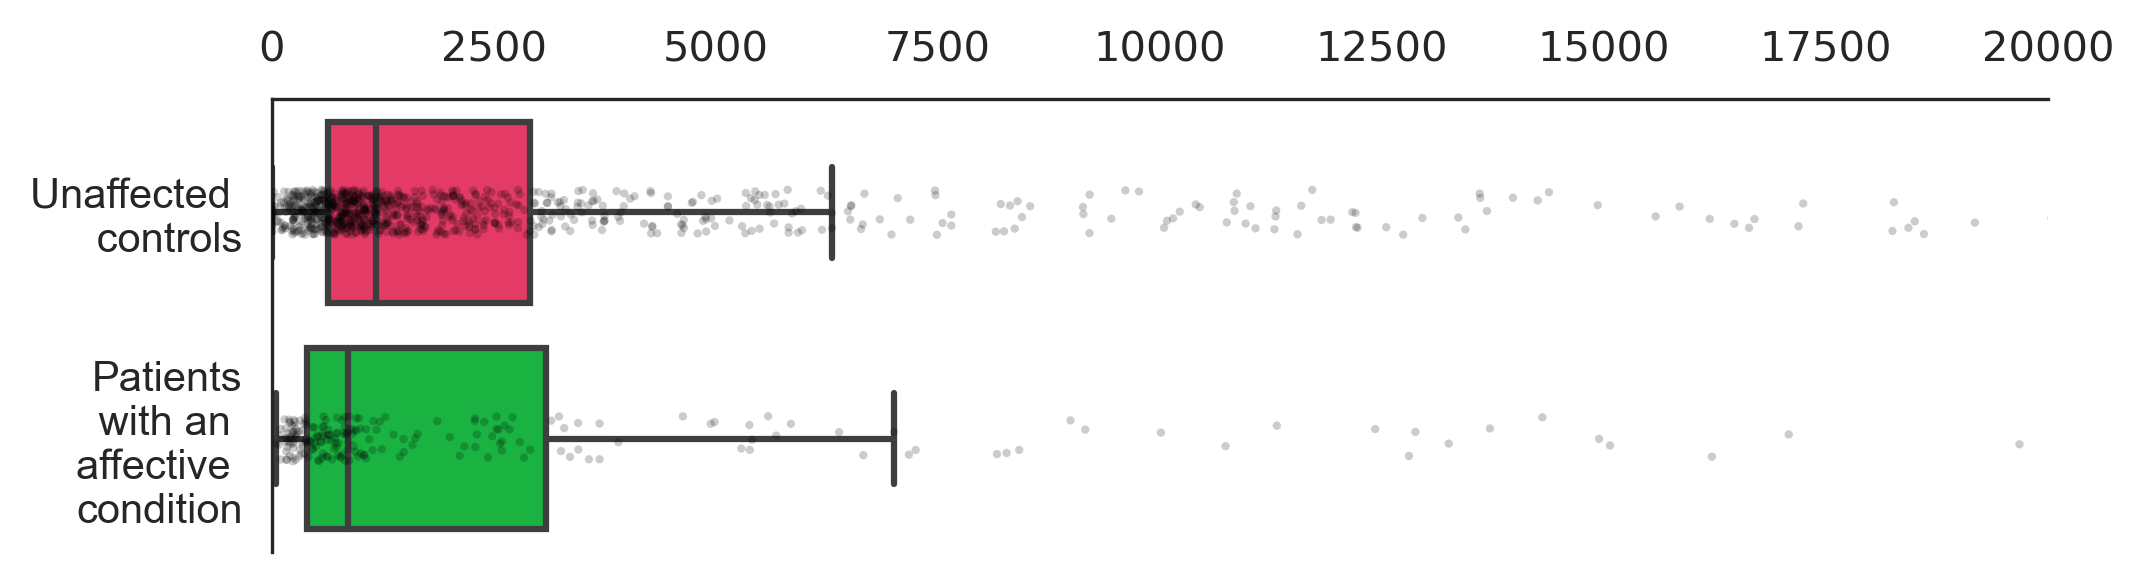

In [13]:
##################
#BOX PLOTS
##################
boxplt_palette = ['#FF1F58', '#00CD36']
fpath = Path(mpl.get_data_path(), "/project_cephfs/3022017.06/ENIGMA_ANX/arial.ttf")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7.64,2
fig, ax = plt.subplots()
sns.set_style("white")
sns.boxplot(data = merged_df[['Unaffected \nControls', 'Patients\n with an \naffective condition']], showfliers = False, palette=boxplt_palette, orient = 'h')
sns.stripplot(data = merged_df[['Unaffected \nControls', 'Patients\n with an \naffective condition']], marker = "o", size = 2, alpha=0.2, color="black", orient = 'h')
plt.yticks([0,1], ['Unaffected \n controls' , 'Patients\n with an \naffective \ncondition'], font = fpath)
plt.xticks(font = fpath)
plt.xlim(0,20000)
sns.despine(top=False, left=False, bottom=True)
plt.show()
fig.savefig('/project_cephfs/3022017.06/ENIGMA_ANX/Z_stat/plots/deviation_count_merged_control_clincial_boxplot_scat_affective_only.png', dpi=300)